In [1]:
%%time
import math
import torch

from botorch.test_functions import SixHumpCamel
from botorch.fit import fit_gpytorch_mll
from botorch.models import SingleTaskGP
from botorch.utils.transforms import standardize, normalize
from gpytorch.mlls import ExactMarginalLogLikelihood

SMOKE_TEST = True

torch.manual_seed(123456)

bounds = torch.tensor(SixHumpCamel._bounds).T
bounds_norm = torch.tensor([[0.0, 0.0], [1.0, 1.0]])
train_X = bounds[0] + (bounds[1] - bounds[0]) * torch.rand(5, 2)
train_Y = SixHumpCamel(negate=True)(train_X).unsqueeze(-1)

train_X = normalize(train_X, bounds=bounds)
train_Y = standardize(train_Y + 0.05 * torch.randn_like(train_Y))

model = SingleTaskGP(train_X, train_Y)
mll = ExactMarginalLogLikelihood(model.likelihood, model)
fit_gpytorch_mll(mll, max_attempts=10)
None

CPU times: user 2.28 s, sys: 1.6 s, total: 3.88 s
Wall time: 4.1 s


/opt/anaconda3/lib/python3.9/site-packages/botorch/models/gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)


ExactMarginalLogLikelihood(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (noise_prior): GammaPrior()
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (model): SingleTaskGP(
    (likelihood): GaussianLikelihood(
      (noise_covar): HomoskedasticNoise(
        (noise_prior): GammaPrior()
        (raw_noise_constraint): GreaterThan(1.000E-04)
      )
    )
    (mean_module): ConstantMean()
    (covar_module): ScaleKernel(
      (base_kernel): MaternKernel(
        (lengthscale_prior): GammaPrior()
        (raw_lengthscale_constraint): Positive()
      )
      (outputscale_prior): GammaPrior()
      (raw_outputscale_constraint): Positive()
    )
  )
)

In [2]:
%%time

from botorch.acquisition.max_value_entropy_search import qLowerBoundMaxValueEntropy

candidate_set_size = 1000 if not SMOKE_TEST else 5
candidate_set = torch.rand(
    candidate_set_size, bounds_norm.size(1), device=bounds.device, dtype=bounds.dtype
)
qGIBBON = qLowerBoundMaxValueEntropy(model, candidate_set)

CPU times: user 5.09 ms, sys: 1.6 ms, total: 6.69 ms
Wall time: 6.53 ms


In [3]:
%%time

from botorch.optim import optimize_acqf

NUM_RESTARTS = 10 if not SMOKE_TEST else 2
RAW_SAMPLES = 512 if not SMOKE_TEST else 4

# for q = 1
candidates, acq_value = optimize_acqf(
    acq_function=qGIBBON,
    bounds=bounds,
    q=1,
    num_restarts=NUM_RESTARTS,
    raw_samples=RAW_SAMPLES,
)
candidates, acq_value

CPU times: user 44.7 ms, sys: 3.05 ms, total: 47.8 ms
Wall time: 46.8 ms


(tensor([[0.2250, 0.0846]]), tensor(0.1546))

In [4]:
%%time

from botorch.optim import optimize_acqf

# for q = 2, sequential optimsiation
candidates, acq_value = optimize_acqf(
    acq_function=qGIBBON,
    bounds=bounds,
    q=2,
    num_restarts=NUM_RESTARTS,
    raw_samples=RAW_SAMPLES,
    sequential=True,
)
candidates, acq_value

CPU times: user 181 ms, sys: 9.05 ms, total: 190 ms
Wall time: 189 ms


(tensor([[0.2250, 0.0846],
         [1.2674, 0.4576]]),
 tensor([0.1546, 0.1350]))

/opt/anaconda3/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


CPU times: user 954 ms, sys: 190 ms, total: 1.14 s
Wall time: 4.87 s


Text(-0.1, 0.5, 'x_2')

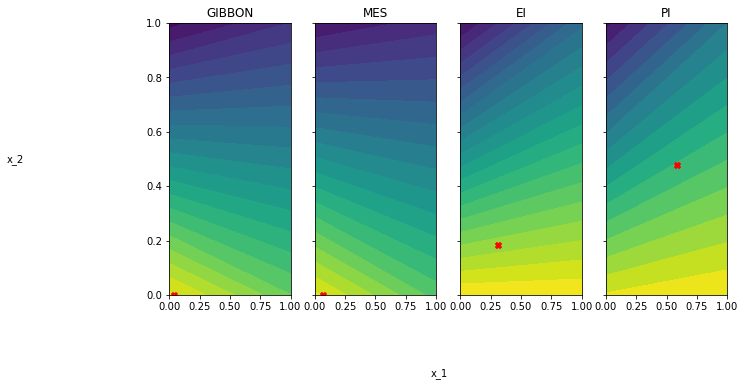

In [5]:
%%time

from botorch.acquisition import (
    ExpectedImprovement,
    ProbabilityOfImprovement,
    qMaxValueEntropy,
)
import matplotlib.pyplot as plt

%matplotlib inline

# prep different acqusition functions
acqs = {}
candidate_set = torch.rand(
    10000, bounds.size(1), device=bounds.device, dtype=bounds.dtype
)
acqs["GIBBON"] = qLowerBoundMaxValueEntropy(model, candidate_set)
acqs["MES"] = qMaxValueEntropy(model, candidate_set)
acqs["EI"] = ExpectedImprovement(model, best_f=train_Y.max())
acqs["PI"] = ProbabilityOfImprovement(model, best_f=train_Y.max())

# prep grid to evaluate acq functions
n = 100 if not SMOKE_TEST else 2
xv, yv = torch.meshgrid([torch.linspace(0, 1, n), torch.linspace(0, 1, n)])
test_x = torch.stack([xv.reshape(n * n, 1), yv.reshape(n * n, 1)], -1)

# eval and maximise acq functions
evals = {}
candidates = {}
for acq in acqs.keys():
    evals[acq] = acqs[acq](test_x).detach().reshape(n, n)
    candidates[acq], _ = optimize_acqf(
        acq_function=acqs[acq], bounds=bounds_norm, q=1, num_restarts=5, raw_samples=100
    )

# plot acqusition function values and chosen points
fig, (ax1, ax2, ax3, ax4) = plt.subplots(
    nrows=1, ncols=4, sharex=True, sharey=True, figsize=(10, 5)
)
ax1.contourf(xv.numpy(), yv.numpy(), evals["GIBBON"].numpy(), levels=20)
ax1.scatter(candidates["GIBBON"][:, 0], candidates["GIBBON"][:, 1], marker="X", c="r")
ax1.set_title("GIBBON")
ax2.contourf(xv.numpy(), yv.numpy(), evals["MES"].numpy(), levels=20)
ax2.scatter(candidates["MES"][:, 0], candidates["MES"][:, 1], marker="X", c="r")
ax2.set_title("MES")
ax3.contourf(xv.numpy(), yv.numpy(), evals["EI"].numpy(), levels=20)
ax3.scatter(candidates["EI"][:, 0], candidates["EI"][:, 1], marker="X", c="r")
ax3.set_title("EI")
ax4.contourf(xv.numpy(), yv.numpy(), evals["PI"].numpy(), levels=20)
ax4.scatter(candidates["PI"][:, 0], candidates["PI"][:, 1], marker="X", c="r")
ax4.set_title("PI")
fig.text(0.5, -0.1, "x_1", ha="center")
fig.text(-0.1, 0.5, "x_2", va="center")

/opt/anaconda3/lib/python3.9/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 2 and Y with dimension 3).
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/botorch/models/gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)
/opt/anaconda3/lib/python3.9/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to 

CPU times: user 3.59 s, sys: 885 ms, total: 4.47 s
Wall time: 3.44 s


Text(0.5, 0, 'Acquisition Function')

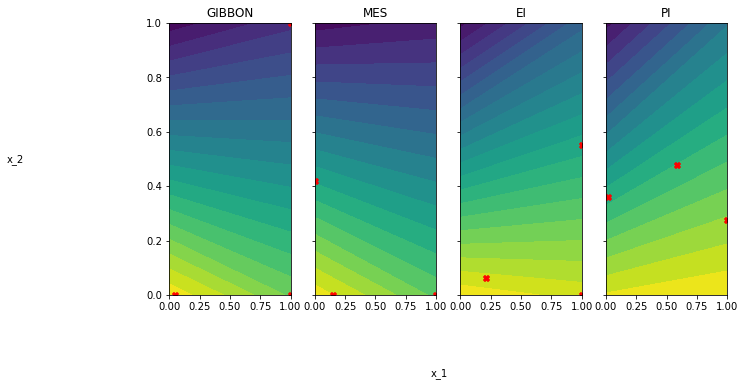

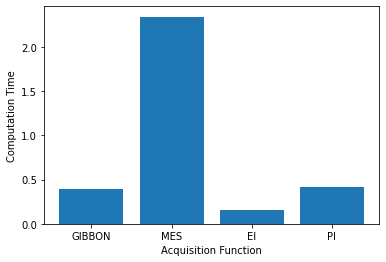

In [6]:
%%time

from botorch.acquisition import qNoisyExpectedImprovement, qProbabilityOfImprovement
from time import time

# prep different acqusition functions
acqs = {}
candidate_set = torch.rand(
    10000, bounds.size(1), device=bounds.device, dtype=bounds.dtype
)
acqs["GIBBON"] = qLowerBoundMaxValueEntropy(model, candidate_set)
acqs["MES"] = qMaxValueEntropy(model, candidate_set)
acqs["EI"] = qNoisyExpectedImprovement(model, train_X)
acqs["PI"] = qProbabilityOfImprovement(model, best_f=train_Y.max())

# prep grid to evaluate acq functions
n = 100 if not SMOKE_TEST else 2
xv, yv = torch.meshgrid([torch.linspace(0, 1, n), torch.linspace(0, 1, n)])
test_x = torch.stack([xv.reshape(n * n, 1), yv.reshape(n * n, 1)], -1)

# eval and maximise acq functions
evals = {}
candidates = {}
times = {}
for acq in acqs.keys():
    evals[acq] = acqs[acq](test_x).detach().reshape(n, n)
    t_0 = time()
    candidates[acq], _ = optimize_acqf(
        acq_function=acqs[acq],
        bounds=bounds_norm,
        q=3,
        num_restarts=5,
        raw_samples=100,
        sequential=True,
    )
    times[acq] = time() - t_0

# plot acqusition function values and chosen points
fig, (ax1, ax2, ax3, ax4) = plt.subplots(
    nrows=1, ncols=4, sharex=True, sharey=True, figsize=(10, 5)
)
ax1.contourf(xv.numpy(), yv.numpy(), evals["GIBBON"].numpy(), levels=20)
ax1.scatter(candidates["GIBBON"][:, 0], candidates["GIBBON"][:, 1], marker="X", c="r")
ax1.set_title("GIBBON")
ax2.contourf(xv.numpy(), yv.numpy(), evals["MES"].numpy(), levels=20)
ax2.scatter(candidates["MES"][:, 0], candidates["MES"][:, 1], marker="X", c="r")
ax2.set_title("MES")
ax3.contourf(xv.numpy(), yv.numpy(), evals["EI"].numpy(), levels=20)
ax3.scatter(candidates["EI"][:, 0], candidates["EI"][:, 1], marker="X", c="r")
ax3.set_title("EI")
ax4.contourf(xv.numpy(), yv.numpy(), evals["PI"].numpy(), levels=20)
ax4.scatter(candidates["PI"][:, 0], candidates["PI"][:, 1], marker="X", c="r")
ax4.set_title("PI")
fig.text(0.5, -0.1, "x_1", ha="center")
fig.text(-0.1, 0.5, "x_2", va="center")

# plot computational overheads
plt.figure()
heights = [times[acq] for acq in acqs.keys()]
plt.bar(acqs.keys(), heights)
plt.ylabel("Computation Time")
plt.xlabel("Acquisition Function")